In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#
import networkx as nx
#
import sklearn
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.dummy import DummyClassifier
#
from sklearn import manifold
import gzip
from collections import OrderedDict
#
import argparse
#
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

In [2]:
def get_network_layer(G, layer=''):
    return G.subgraph([n for n, d in G.nodes(data=True) if (d.get('layer') == layer)]).copy()

In [3]:
celltype = 'spermatocyte'
network = 'thr'
threshold = 0.5
threshold_str = str(threshold).replace('.', 'p')
layer = species = 'MM'

In [4]:
# Load Network
rfnet = '../../04-network/results/network/{celltype:s}/net-{celltype:s}-{network:s}-{threshold:s}.gpickle'.format(celltype=celltype, network=network, threshold=threshold_str)
G = nx.read_gpickle(rfnet)
# layer
Gt = get_network_layer(G, layer=layer)
#

In [5]:
df = pd.DataFrame.from_dict(dict(Gt.nodes(data=True)), orient='index')

In [6]:
# Load DEG
rfdeg = '../../02-core_genes/results/DE/{species:s}-DE_genes.csv.gz'.format(celltype=celltype, species=species)
dfdeg = pd.read_csv(rfdeg, index_col=0)
#
dfdeg = dfdeg.loc[dfdeg.index.isin(df.index), :]
#
#display(dfdeg)

In [7]:
# Load FPKM
rffpkm = '../../02-core_genes/results/FPKM/{species:s}/{species:s}-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype, species=species)
dffpkm = pd.read_csv(rffpkm, index_col=0)
#
dffpkm = dffpkm.loc[dffpkm.index.isin(df.index), :]
#
#display(dffpkm)

In [8]:
# Conserved
path_fpkm = '../../02-core_genes/results/FPKM/'
df_HS = pd.read_csv(path_fpkm + 'HS/HS-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype), index_col='id_string')
df_MM = pd.read_csv(path_fpkm + 'MM/MM-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype), index_col='id_string')
df_DM = pd.read_csv(path_fpkm + 'DM/DM-FPKM-{celltype:s}.csv.gz'.format(celltype=celltype), index_col='id_string')

dict_string_gene_HS = df_HS['id_gene'].to_dict()
dict_string_gene_MM = df_MM['id_gene'].to_dict()
dict_string_gene_DM = df_DM['id_gene'].to_dict()

path = '../../02-core_genes/results/'
dfM = pd.read_csv(path + 'meta-genes/meta-{celltype:s}-genes.csv.gz'.format(celltype=celltype), index_col='id_eggnog', usecols=['id_eggnog', 'id_string_HS', 'id_string_MM', 'id_string_DM'])

dfM['id_string_HS'] = dfM['id_string_HS'].apply(lambda x: x.split(',') if not pd.isnull(x) else [])
dfM['id_string_MM'] = dfM['id_string_MM'].apply(lambda x: x.split(',') if not pd.isnull(x) else [])
dfM['id_string_DM'] = dfM['id_string_DM'].apply(lambda x: x.split(',') if not pd.isnull(x) else [])

dfM['id_gene_HS'] = dfM['id_string_HS'].apply(lambda x: [dict_string_gene_HS[i] for i in x])
dfM['id_gene_MM'] = dfM['id_string_MM'].apply(lambda x: [dict_string_gene_MM[i] for i in x])
dfM['id_gene_DM'] = dfM['id_string_DM'].apply(lambda x: [dict_string_gene_DM[i] for i in x])

dfM = dfM[['id_gene_HS', 'id_gene_MM', 'id_gene_DM']]
# Only keep meta genes with homologs in at least two species
dfM2 = dfM.loc[dfM.applymap(len).applymap(bool).sum(axis='columns') >= 2, :]
# Only keep meta genes with homologs in all three species
dfM3 = dfM.loc[dfM.applymap(len).applymap(bool).sum(axis='columns') == 3, :]
#
dict_conserved = {gene: True for gene in dfM3['id_gene_' + layer].explode().tolist()}
#
df['conserved'] = df.index.map(dict_conserved)
df['conserved'].fillna(False, inplace=True)

In [9]:
# Load Core genes
rfcore = '../../02-core_genes/results/pipeline-core/{species:s}_meiotic_genes.csv'.format(species=species)
dfc = pd.read_csv(rfcore, index_col=0)
#
core_genes = dfc.index.tolist()

In [10]:
# Load PCA
rfpcad = '../../04-network/results/pca/{celltype:s}/{layer:s}/pca-{celltype:s}-{network:s}-{threshold:s}-{layer:s}-dim.csv.gz'.format(celltype=celltype, network=network, threshold=threshold_str, layer=layer)
#rfpcav = '../../04-network/results/pca/{celltype:s}/{layer:s}/pca-{celltype:s}-{network:s}-{threshold:s}-{layer:s}-s.csv.gz'.format(celltype=celltype, network=network, threshold=threshold_str, layer=layer)
dfpca = pd.read_csv(rfpcad, index_col=0)
#spcav = pd.read_csv(rfpcav, index_col=0, squeeze=True)

In [11]:
# Load Modules
rfmod = '../../05-data-analysis/entropy-based-modules/results/pca-entropy/{celltype:s}/{layer:s}/pca-{celltype:s}-{network:s}-{threshold:s}-{layer:s}-modules.csv.gz'.format(celltype=celltype, network=network, threshold=threshold_str, layer=layer)
dfmod = pd.read_csv(rfmod, index_col=0)

modcols = []
for (mid, mname), dfmodt in dfmod.groupby(['module-id', 'module-name']):
    mod_genes = dfmodt.index.tolist()
    modcol = 'module-'+str(mid)
    df[modcol] = df.index.map(lambda x: 1 if x in mod_genes else 0)
    modcols.append(modcol)

In [12]:
# Edge as column features
dfadj = nx.to_pandas_adjacency(Gt).astype(bool)
display(dfadj)

,ENSMUSG00000034151,ENSMUSG00000030654,ENSMUSG00000003549,ENSMUSG00000033808,ENSMUSG00000017664,ENSMUSG00000015790,ENSMUSG00000043445,ENSMUSG00000007783,ENSMUSG00000013089,ENSMUSG00000018846,ENSMUSG00000053199,ENSMUSG00000059486,ENSMUSG00000003208,ENSMUSG00000029544,ENSMUSG00000074501,ENSMUSG00000007610,ENSMUSG00000010342,ENSMUSG00000026127,ENSMUSG00000032512,ENSMUSG00000041308,ENSMUSG00000040260,ENSMUSG00000057666,ENSMUSG00000021572,ENSMUSG00000019814,ENSMUSG00000055762,ENSMUSG00000035049,ENSMUSG00000072235,ENSMUSG00000079470,ENSMUSG00000021124,ENSMUSG00000019961,ENSMUSG00000046460,ENSMUSG00000050967,ENSMUSG00000043923,ENSMUSG00000047150,ENSMUSG00000034484,ENSMUSG00000038615,ENSMUSG00000094985,ENSMUSG00000034595,ENSMUSG00000037062,ENSMUSG00000039648,ENSMUSG00000028059,ENSMUSG00000074576,ENSMUSG00000091460,ENSMUSG00000027641,ENSMUSG00000030291,ENSMUSG00000074227,ENSMUSG00000053819,ENSMUSG00000073208,ENSMUSG00000037216,ENSMUSG00000028403,ENSMUSG00000038324,ENSMUSG00000037674,ENSMUSG00000039509,ENSMUSG00000030359,ENSMUSG00000046782,ENSMUSG00000058886,ENSMUSG00000039740,ENSMUSG00000020483,ENSMUSG00000042446,ENSMUSG00000020381,ENSMUSG00000031584,ENSMUSG00000034518,ENSMUSG00000024142,ENSMUSG00000057177,ENSMUSG00000040811,ENSMUSG00000038738,ENSMUSG00000037166,ENSMUSG00000022151,ENSMUSG00000020170,ENSMUSG00000041736,ENSMUSG00000038583,ENSMUSG00000038633,ENSMUSG00000057778,ENSMUSG00000066640,ENSMUSG00000024472,ENSMUSG00000020948,ENSMUSG00000018677,ENSMUSG00000021257,ENSMUSG00000033411,ENSMUSG00000039050,ENSMUSG00000021676,ENSMUSG00000025026,ENSMUSG00000028899,ENSMUSG00000006127,ENSMUSG00000057058,ENSMUSG00000033054,ENSMUSG00000023904,ENSMUSG00000054263,ENSMUSG00000002603,ENSMUSG00000030663,ENSMUSG00000001552,ENSMUSG00000030543,ENSMUSG00000022020,ENSMUSG00000024095,ENSMUSG00000029062,ENSMUSG00000021288,ENSMUSG00000028830,ENSMUSG00000038022,ENSMUSG00000039195,ENSMUSG00000078652,ENSMUSG00000032051,ENSMUSG00000029634,ENSMUSG00000041625,ENSMUSG00000022792,ENSMUSG00000018707,ENSMUSG00000051910,ENSMUSG00000031605,ENSMUSG00000048495,ENSMUSG00000017837,ENSMUSG00000029314,ENSMUSG00000003555,ENSMUSG00000055491,ENSMUSG00000062825,ENSMUSG00000035671,ENSMUSG00000094483,ENSMUSG00000002846,ENSMUSG00000034101,ENSMUSG00000041068,ENSMUSG00000062762,ENSMUSG00000029703,ENSMUSG00000038759,ENSMUSG00000048416,ENSMUSG00000022802,ENSMUSG00000030380,ENSMUSG00000029726,ENSMUSG00000070471,ENSMUSG00000039367,ENSMUSG00000090544,ENSMUSG00000025239,ENSMUSG00000003528,ENSMUSG00000031991,ENSMUSG00000028676,ENSMUSG00000075705,ENSMUSG00000040188,ENSMUSG00000044786,ENSMUSG00000022538,ENSMUSG00000037752,ENSMUSG00000032323,ENSMUSG00000055065,ENSMUSG00000046755,ENSMUSG00000049832,ENSMUSG00000054766,ENSMUSG00000018932,ENSMUSG00000024019,ENSMUSG00000051185,ENSMUSG00000046408,ENSMUSG00000027002,ENSMUSG00000039384,ENSMUSG00000010803,ENSMUSG00000025439,ENSMUSG00000042628,ENSMUSG00000020230,ENSMUSG00000020541,ENSMUSG00000049517,ENSMUSG00000070544,ENSMUSG00000002329,ENSMUSG00000042269,ENSMUSG00000039753,ENSMUSG00000038535,ENSMUSG00000037331,ENSMUSG00000024782,ENSMUSG00000057246,ENSMUSG00000074165,ENSMUSG00000023106,ENSMUSG00000030996,ENSMUSG00000002871,ENSMUSG00000023330,ENSMUSG00000051413,ENSMUSG00000017830,ENSMUSG00000037426,ENSMUSG00000036202,ENSMUSG00000040435,ENSMUSG00000006005,ENSMUSG00000040563,ENSMUSG00000025572,ENSMUSG00000038416,ENSMUSG00000038525,ENSMUSG00000063458,ENSMUSG00000094904,ENSMUSG00000012443,ENSMUSG00000027962,ENSMUSG00000037110,ENSMUSG00000028256,ENSMUSG00000040731,ENSMUSG00000042380,ENSMUSG00000041645,ENSMUSG00000024896,ENSMUSG00000044468,ENSMUSG00000091175,ENSMUSG00000027132,ENSMUSG00000026288,ENSMUSG00000041840,ENSMUSG00000028522,ENSMUSG00000091017,ENSMUSG00000026820,ENSMUSG00000047104,ENSMUSG00000020698,ENSMUSG00000027534,ENSMUSG00000064289,ENSMUSG00000041632,ENSMUSG00000031865,ENSMUSG00000025794,ENSMUSG00000059820,ENSMUSG00000001289,ENSMUSG00000050545,ENSMUSG00000024897,ENSMUSG00000025934,ENSMUSG00000036181,ENSMUSG00000050612,ENSMUSG00000019470,ENSMUSG00

In [13]:
# Set core
df.loc[df.index.isin(core_genes), 'core'] = True
df['core'] = df['core'].fillna(False)

# Set DEG variables
if species == 'DM':
    df['Middle_vs_Apical'] = dfdeg['Middle_vs_Apical']
    df['Middle_vs_Apical'].fillna(False, inplace=True)

    df['Middle_vs_Basal'] = dfdeg['Middle_vs_Apical']
    df['Middle_vs_Basal'].fillna(False, inplace=True)
    #
    df['logFC_MiddleApical'] = dfdeg['logFC_MiddleApical']
    df['logFC_MiddleApical'].fillna(0, inplace=True)
    #
    df['logFC_BasalMiddle'] = dfdeg['logFC_BasalMiddle']
    df['logFC_BasalMiddle'].fillna(0, inplace=True)
else:
    df['Cyte_vs_Gonia'] = dfdeg['Cyte_vs_Gonia']
    df['Cyte_vs_Gonia'].fillna(False, inplace=True)

    df['Tid_vs_Cyte'] = dfdeg['Tid_vs_Cyte']
    df['Tid_vs_Cyte'].fillna(False, inplace=True)
    #
    df['logFC_CyteGonia'] = dfdeg['logFC_CyteGonia']
    df['logFC_CyteGonia'].fillna(0, inplace=True)
    #
    df['logFC_TidCyte'] = dfdeg['logFC_TidCyte']
    df['logFC_TidCyte'].fillna(0, inplace=True)

In [14]:
# Set Direct Experimental Evidence
dfe_DM_our = pd.read_csv('../../03-screened-data/data/core_DM_screened_2020-12-23.csv', index_col=0, usecols=['id_gene', 'Our DM pheno code'])
dfe_DM_our = dfe_DM_our.loc[(dfe_DM_our['Our DM pheno code'].notnull()), 'Our DM pheno code']
dfe_DM_lit = pd.read_csv('../../03-screened-data/data/literature_DM_2021-01-05.csv', index_col=0, squeeze=True)
#
def our_lit_pheno(r):
    if pd.notnull(r['Our DM pheno code']):
        return r['Our DM pheno code']
    elif pd.notnull(r['Others DM pheno code']):
        return r['Others DM pheno code']
    else:
        return np.nan
dfe_DM = pd.concat([dfe_DM_our, dfe_DM_lit], axis=1).apply(our_lit_pheno, axis='columns')
#
dfe_MM = pd.read_csv('../../03-screened-data/data/literature_MM_2021-01-05.csv', index_col=0, squeeze=True)
dfe_HS = pd.read_csv('../../03-screened-data/data/literature_HS_2021-01-05.csv', index_col=0, squeeze=True)
#
if species == 'DM':
    df['dir-pheno'] = dfe_DM#['Our DM pheno code']
elif species == 'MM':
    df['dir-pheno'] = dfe_MM#['Others MM pheno code']
elif species == 'HS':
    df['dir-pheno'] = dfe_HS#['Others HS pheno code']

In [15]:
dfMe = pd.DataFrame(index=dfM.index)
# Set Indirect Experimental Evidence (from homologs)
dfMe['dir_pheno_HS'] = dfM['id_gene_HS'].map(lambda x: [dfe_HS.get(i) for i in x if i in dfe_HS])
dfMe['dir_pheno_MM'] = dfM['id_gene_MM'].map(lambda x: [dfe_MM.get(i) for i in x if i in dfe_MM])
dfMe['dir_pheno_DM'] = dfM['id_gene_DM'].map(lambda x: [dfe_DM.get(i) for i in x if i in dfe_DM])
#
# Only keep meta genes with homologs in at least two species
dfMe1 = dfMe.loc[dfMe.applymap(len).applymap(bool).sum(axis='columns') > 0, :]

In [16]:
dfM.loc['3B93Y',:].to_frame()

,3B93Y
id_gene_HS,"[ENSG00000067842, ENSG00000058668, ENSG0000015..."
id_gene_MM,"[ENSMUSG00000019943, ENSMUSG00000031376, ENSMU..."
id_gene_DM,[FBgn0259214]


In [17]:
dfMe1

,dir_pheno_HS,dir_pheno_MM,dir_pheno_DM
id_eggnog,,,
3B93Y,[],[C],[]
3B943,[],[],[D]
3B94U,[],[A],[]
3B95U,[],[],[D]
3B95V,[],[],[C]
...,...,...,...
3BUE8,[],[],[B]
3BUGP,[],[],[D]
3BYCJ,[],[],[D]


In [18]:
if species == 'DM':
    # add indirect MM and HS
    dfMet = dfMe[['dir_pheno_HS', 'dir_pheno_MM']]
    dfMet = dfMet.loc[dfMet.applymap(len).applymap(bool).sum(axis='columns') > 0, :]
    dfMet['ind-pheno'] = (dfMe['dir_pheno_HS'] + dfMe['dir_pheno_MM']).apply(lambda x: '/'.join(sorted(set(x))))
    dfMet = dfMet['ind-pheno']
    #
    dfMt = dfM.loc[dfMet.index, 'id_gene_DM'].explode().to_frame()
    dfMt['ind-pheno'] = dfMet
    dfMt = dfMt.set_index('id_gene_DM')
    #
    df['ind-pheno'] = dfMt['ind-pheno']
elif species == 'MM':
    # add indirect DM and HS
    dfMet = dfMe[['dir_pheno_HS', 'dir_pheno_DM']]
    dfMet = dfMet.loc[dfMet.applymap(len).applymap(bool).sum(axis='columns') > 0, :]
    dfMet['ind-pheno'] = (dfMe['dir_pheno_HS'] + dfMe['dir_pheno_DM']).apply(lambda x: '/'.join(sorted(set(x))))
    dfMet = dfMet['ind-pheno']
    #
    dfMt = dfM.loc[dfMet.index, 'id_gene_MM'].explode().to_frame()
    dfMt['ind-pheno'] = dfMet
    dfMt = dfMt.set_index('id_gene_MM')
    #
    df['ind-pheno'] = dfMt['ind-pheno']
elif species == 'HS':
    # add indirect DM and MM
    dfMet = dfMe[['dir_pheno_MM', 'dir_pheno_DM']]
    dfMet = dfMet.loc[dfMet.applymap(len).applymap(bool).sum(axis='columns') > 0, :]
    dfMet['ind-pheno'] = (dfMe['dir_pheno_MM'] + dfMe['dir_pheno_DM']).apply(lambda x: '/'.join(sorted(set(x))))
    dfMet = dfMet['ind-pheno']
    #
    dfMt = dfM.loc[dfMet.index, 'id_gene_HS'].explode().to_frame()
    dfMt['ind-pheno'] = dfMet
    dfMt = dfMt.set_index('id_gene_HS')
    #
    df['ind-pheno'] = dfMt['ind-pheno']

In [19]:
def dir_ind_pheno(r):
    if pd.notnull(r['dir-pheno']):
        return r['dir-pheno']
    elif pd.notnull(r['ind-pheno']):
        return 'indirect'
    else:
        return np.nan
df['phenotype'] = df[['dir-pheno', 'ind-pheno']].apply(dir_ind_pheno, axis='columns')

In [20]:
df['dir-pheno'].value_counts()

A    22
B    20
G     8
C     6
D     5
E     4
H     4
Name: dir-pheno, dtype: int64

In [21]:
# Degree
dict_degree = {n: d for n, d in list(Gt.degree())}
df['degree'] = df.index.map(dict_degree)
# Degree weight
dict_degree = {n: d for n, d in list(Gt.degree(weight='weight'))}
df['degree-weight'] = df.index.map(dict_degree)

In [22]:
# Degree Centrality
dict_degree_centrality = nx.degree_centrality(Gt)
df['degree-centrality'] = df.index.map(dict_degree_centrality)

In [ ]:
# Betweeness Centrality
dict_betweenness_centrality = nx.betweenness_centrality(Gt)
df['betweenness-centrality'] = df.index.map(dict_betweenness_centrality)

In [23]:
# Eigenvector Centrality
dict_eigenvector_centrality = nx.eigenvector_centrality(Gt, weight='weight')
df['eigenvector-centrality'] = df.index.map(dict_eigenvector_centrality)

In [24]:
# Page rank
dict_pagerank = nx.pagerank(Gt)
df['pagerank'] = df.index.map(dict_pagerank)

In [25]:
# Average neighbor degree
dict_average_neighbor_degree = nx.average_neighbor_degree(Gt, weight='weight')
df['avg-neighbor-degree'] = df.index.map(dict_average_neighbor_degree)

In [26]:
#display(df)
display(df.loc[df['dir-pheno'].notnull(), :])

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-6,module-7,module-8,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,dir-pheno,ind-pheno,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSMUSG00000028830,10090.ENSMUSP00000099667,AU040320,31.826905,protein_coding,4.331876,MM,True,0,0,0,0,0,0,0,0,True,True,True,2.462090,-0.040256,B,NaN,B,14,8.770,0.001268,1.926147e-05,0.000044,30.256899
ENSMUSG00000021270,10090.ENSMUSP00000091921,Hsp90aa1,2617.376058,protein_coding,10.622023,MM,True,0,0,0,0,1,0,1,0,True,True,True,1.526227,-0.615292,A,A,A,466,358.825,0.042195,7.924730e-03,0.000633,157.962269
ENSMUSG00000039804,10090.ENSMUSP00000046388,Ncoa5,62.157897,protein_coding,5.262149,MM,True,0,0,0,0,0,0,0,0,True,True,True,1.087020,-0.655786,B,NaN,B,43,28.159,0.003894,3.320316e-04,0.000065,111.288185
ENSMUSG00000004880,10090.ENSMUSP00000005003,Lbr,20.369059,protein_coding,3.728454,MM,True,0,0,0,0,0,0,0,0,True,True,True,-0.248903,-2.184413,G,NaN,G,60,38.918,0.005433,3.395168e-04,0.000111,87.646693
ENSMUSG00000031446,10090.ENSMUSP00000016680,Cul4a,67.584142,protein_coding,5.380411,MM,True,0,0,0,0,0,0,0,1,True,True,True,0.974935,-1.500989,A,NaN,A,181,155.861,0.016389,1.522332e-02,0.000209,221.471253
ENSMUSG00000018554,10090.ENSMUSP00000018698,Ybx2,1357.011027,protein_coding,9.673976,MM,True,0,0,0,0,0,0,0,0,True,True,True,9.973966,0.108663,B,B,B,26,14.788,0.002354,1.316968e-04,0.000057,80.267311
ENSMUSG00000030127,10090.ENSMUSP00000108058,Cops7a,188.340515,protein_coding,6.836033,MM,True,1,0,0,0,0,0,0,0,True,True,True,2.927257,-0.294512,G,D,G,203,178.209,0.018381,3.421345e-02,0.000214,235.627415
ENSMUSG00000089911,10090.ENSMUSP00000029570,Mfsd14a,86.936460,protein_coding,5.735981,MM,True,0,0,0,0,0,0,0,0,True,True,True,1.761842,-0.132512,B,F,B,21,12.331,0.001901,6.268589e-06,0.000070,22.398994
ENSMUSG00000032101,10090.ENSMUSP00000034612,Ddx25,190.780289,protein_coding,6.855156,MM,True,0,0,0,0,0,0,0,0,True,True,True,6.758987,0.033117,B,B,B,34,24.815,0.003079,1.989294e-04,0.000076,101.297844
ENSMUSG00000028790,10090.ENSMUSP00000066516,Khdrbs1,65.650041,protein_coding,5.339406,MM,True,0,0,0,0,0,0,0,0,True,True,True,-0.445789,-1.586812,A,C,A,99,64.561,0.008964,1.162297e-03,0.000121,154.729806


## Plots

In [27]:
display(df)
dftc = df.loc[df['core'] == True]
dftn = df.loc[df['core'] == False]

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-6,module-7,module-8,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,dir-pheno,ind-pheno,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSMUSG00000034151,10090.ENSMUSP00000103407,Zbbx,241.605326,protein_coding,7.193482,MM,False,0,0,0,0,0,0,0,0,False,True,True,6.433304,1.727338,NaN,NaN,NaN,7,4.193,0.000634,0.000022,0.000028,38.065109
ENSMUSG00000030654,10090.ENSMUSP00000032888,Arl6ip1,207.484014,protein_coding,6.975305,MM,True,0,0,0,0,0,0,0,0,True,True,True,2.258410,-2.240264,NaN,NaN,NaN,16,9.893,0.001449,0.000114,0.000043,81.360457
ENSMUSG00000003549,10090.ENSMUSP00000003645,Ercc1,22.935673,protein_coding,3.886110,MM,True,0,0,0,0,0,0,0,1,False,True,True,-0.595956,0.211684,NaN,NaN,NaN,193,159.052,0.017476,0.006125,0.000225,193.537768
ENSMUSG00000033808,10090.ENSMUSP00000087500,Tmem87a,15.511289,protein_coding,3.369094,MM,True,0,0,0,0,0,0,0,0,False,True,True,-0.779520,-0.751924,NaN,NaN,NaN,9,5.106,0.000815,0.000008,0.000050,28.826870
ENSMUSG00000017664,10090.ENSMUSP00000104923,Slc35c2,21.406173,protein_coding,3.795157,MM,True,0,0,0,0,0,0,0,0,False,True,True,1.440158,-0.317071,NaN,NaN,NaN,18,12.086,0.001630,0.000007,0.000069,21.704700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000025544,10090.ENSMUSP00000026624,Tm9sf2,66.808282,protein_coding,5.364521,MM,True,0,0,0,0,0,0,0,0,False,True,True,-0.001663,0.947910,NaN,NaN,NaN,6,3.283,0.000543,0.000112,0.000021,115.280231
ENSMUSG00000038569,10090.ENSMUSP00000036177,Rad9b,25.943392,protein_coding,4.053819,MM,True,0,0,0,0,0,0,0,0,True,True,True,3.229450,-1.191661,NaN,B,indirect,54,43.720,0.004890,0.001055,0.000087,164.913426
ENSMUSG00000023942,10090.ENSMUSP00000131976,Slc29a1,36.134222,protein_coding,4.505916,MM,True,0,0,0,0,0,0,0,0,False,True,True,2.086533,-0.803279,NaN,NaN,NaN,15,9.274,0.001358,0.000059,0.000041,78.223528
ENSMUSG00000031755,10090.ENSMUSP00000034206,Bbs2,37.217822,protein_coding,4.547755,MM,False,0,0,0,0,0,0,0,0,False,True,True,2.598359,-0.582728,NaN,NaN,NaN,44,30.043,0.003984,0.000316,0.000076,90.306960


core: 833
n-core: 10212


Text(0.5, 1.0, 'degree')

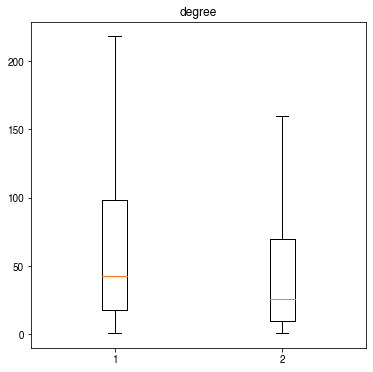

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
var = 'degree'
print('core:', len(dftc))
print('n-core:', len(dftn))
bp = ax.boxplot([dftc[var], dftn[var]], showfliers=False)
ax.set_title(var)

indirect    423
A            22
B            20
G             8
C             6
D             5
E             4
H             4
Name: phenotype, dtype: int64


<AxesSubplot:xlabel='logFPKM', ylabel='pagerank'>

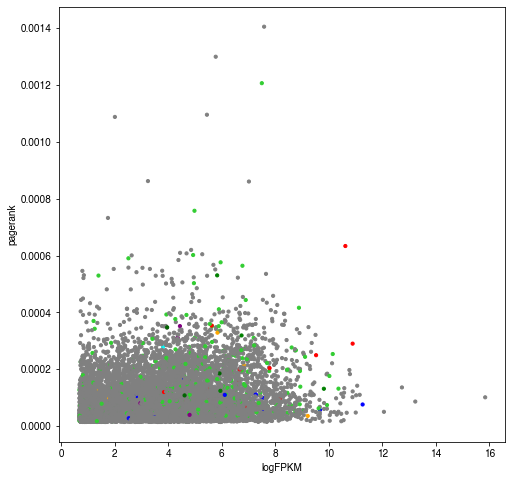

In [29]:
print(df['phenotype'].value_counts())
c = df['phenotype'].map({'A': 'red', 'B': 'blue', 'C':'green', 'D':'purple', 'E': 'cyan', 'F':'magenta', 'G':'orange', 'H': 'darkgreen', np.nan:'gray', 'indirect':'limegreen'})
df.plot(x='logFPKM', y='pagerank', kind='scatter', c=c, s=10, figsize=(8,8))


In [32]:
df['phenotype'] = df['phenotype'].fillna(0)
df.loc[df.isnull().any(axis=1), :]

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-7,module-8,module-10,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,dir-pheno,ind-pheno,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSG00000185803,9606.ENSP00000436768,SLC52A2,1.942320,protein_coding,2.083619,HS,False,0,0,0,0,0,0,0,0,False,False,False,0.000000,0.000000,NaN,NaN,0,7,3.793,0.000618,0.000008,0.000030,26.167677
ENSG00000102743,9606.ENSP00000342267,SLC25A15,3.424111,protein_coding,3.033660,HS,True,0,0,0,0,0,0,0,0,False,True,True,1.305708,-5.425242,NaN,NaN,0,11,6.132,0.000972,0.000041,0.000029,71.628506
ENSG00000131067,9606.ENSP00000338964,GGT7,1.099834,protein_coding,1.262980,HS,True,0,0,0,0,0,0,0,0,False,True,False,0.059470,0.000000,NaN,A,indirect,47,35.332,0.004152,0.000060,0.000095,54.807455
ENSG00000166262,9606.ENSP00000299338,FAM227B,13.073425,protein_coding,4.594802,HS,False,0,0,0,0,0,0,0,0,False,True,True,0.548863,-3.032858,NaN,NaN,0,4,2.642,0.000353,0.000003,0.000025,34.478425
ENSG00000168264,9606.ENSP00000355568,IRF2BP2,5.439264,protein_coding,3.384873,HS,True,0,0,0,0,0,0,0,0,False,True,True,-0.999716,0.220858,NaN,NaN,0,9,5.104,0.000795,0.000069,0.000027,43.321513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000162852,9606.ENSP00000355470,CNST,5.593046,protein_coding,3.126337,HS,False,0,0,0,0,0,0,0,0,False,True,True,-0.880134,3.413244,NaN,NaN,0,6,4.346,0.000530,0.000050,0.000024,111.286240
ENSG00000163166,9606.ENSP00000295321,IWS1,13.364771,protein_coding,4.652439,HS,True,0,0,0,0,0,0,0,0,False,True,True,-1.245914,-0.393241,NaN,NaN,0,86,69.979,0.007597,0.004949,0.000101,221.554295
ENSG00000153060,9606.ENSP00000283025,TEKT5,9.361453,protein_coding,3.752909,HS,False,0,0,0,0,0,0,0,0,False,True,True,0.397592,2.342642,NaN,NaN,0,5,2.809,0.000442,0.000001,0.000030,14.451406
ENSG00000121064,9606.ENSP00000262288,SCPEP1,3.985583,protein_coding,3.207044,HS,True,0,0,0,0,0,0,0,0,False,True,True,0.562656,-10.668679,NaN,NaN,0,5,3.656,0.000442,0.000013,0.000021,48.815372


# ML

In [33]:
display(df)
#
logFCcols = ['logFC_MiddleApical', 'logFC_BasalMiddle'] if species == 'DM' else ['logFC_CyteGonia', 'logFC_TidCyte']
cellcompcols = ['Middle_vs_Apical', 'Middle_vs_Basal'] if species == 'DM' else ['Cyte_vs_Gonia', 'Tid_vs_Cyte']
#
num_cols = logFCcols + ['degree', 'degree-weight', 'degree-centrality', 'eigenvector-centrality', 'pagerank', 'avg-neighbor-degree'] #, 'betweenness-centrality']
bin_cols = cellcompcols + modcols + ['conserved']
cat_cols = ['biotype']
#
cat_features = df[cat_cols].fillna(0).T.to_dict().values()
num_features = df[num_cols].values
bin_features = df[bin_cols]
#
DV = sklearn.feature_extraction.DictVectorizer(sparse=False)
SS = sklearn.preprocessing.StandardScaler()
MMS = sklearn.preprocessing.MinMaxScaler()
#
X_cat = DV.fit_transform(cat_features)
X_num = MMS.fit_transform(num_features)
X_bin = bin_features
#
features = DV.feature_names_ + num_cols + bin_cols
print(features)
#
X = np.hstack((X_cat, X_num, X_bin))
y = df['phenotype'].fillna(0).astype(bool).values
#y = df['logFC_CyteGonia'].apply(lambda x: True if x > 1 else False).values

,id_string,label,TPM,biotype,logFPKM,layer,conserved,module-1,module-2,module-3,module-4,module-5,module-7,module-8,module-10,core,Cyte_vs_Gonia,Tid_vs_Cyte,logFC_CyteGonia,logFC_TidCyte,dir-pheno,ind-pheno,phenotype,degree,degree-weight,degree-centrality,eigenvector-centrality,pagerank,avg-neighbor-degree
ENSG00000185803,9606.ENSP00000436768,SLC52A2,1.942320,protein_coding,2.083619,HS,False,0,0,0,0,0,0,0,0,False,False,False,0.000000,0.000000,NaN,NaN,0,7,3.793,0.000618,0.000008,0.000030,26.167677
ENSG00000102743,9606.ENSP00000342267,SLC25A15,3.424111,protein_coding,3.033660,HS,True,0,0,0,0,0,0,0,0,False,True,True,1.305708,-5.425242,NaN,NaN,0,11,6.132,0.000972,0.000041,0.000029,71.628506
ENSG00000131067,9606.ENSP00000338964,GGT7,1.099834,protein_coding,1.262980,HS,True,0,0,0,0,0,0,0,0,False,True,False,0.059470,0.000000,NaN,A,indirect,47,35.332,0.004152,0.000060,0.000095,54.807455
ENSG00000166262,9606.ENSP00000299338,FAM227B,13.073425,protein_coding,4.594802,HS,False,0,0,0,0,0,0,0,0,False,True,True,0.548863,-3.032858,NaN,NaN,0,4,2.642,0.000353,0.000003,0.000025,34.478425
ENSG00000168264,9606.ENSP00000355568,IRF2BP2,5.439264,protein_coding,3.384873,HS,True,0,0,0,0,0,0,0,0,False,True,True,-0.999716,0.220858,NaN,NaN,0,9,5.104,0.000795,0.000069,0.000027,43.321513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000162852,9606.ENSP00000355470,CNST,5.593046,protein_coding,3.126337,HS,False,0,0,0,0,0,0,0,0,False,True,True,-0.880134,3.413244,NaN,NaN,0,6,4.346,0.000530,0.000050,0.000024,111.286240
ENSG00000163166,9606.ENSP00000295321,IWS1,13.364771,protein_coding,4.652439,HS,True,0,0,0,0,0,0,0,0,False,True,True,-1.245914,-0.393241,NaN,NaN,0,86,69.979,0.007597,0.004949,0.000101,221.554295
ENSG00000153060,9606.ENSP00000283025,TEKT5,9.361453,protein_coding,3.752909,HS,False,0,0,0,0,0,0,0,0,False,True,True,0.397592,2.342642,NaN,NaN,0,5,2.809,0.000442,0.000001,0.000030,14.451406
ENSG00000121064,9606.ENSP00000262288,SCPEP1,3.985583,protein_coding,3.207044,HS,True,0,0,0,0,0,0,0,0,False,True,True,0.562656,-10.668679,NaN,NaN,0,5,3.656,0.000442,0.000013,0.000021,48.815372


['biotype', 'biotype=lncRNA', 'biotype=polymorphic_pseudogene', 'biotype=processed_pseudogene', 'biotype=protein_coding', 'biotype=transcribed_processed_pseudogene', 'biotype=transcribed_unitary_pseudogene', 'biotype=transcribed_unprocessed_pseudogene', 'biotype=unprocessed_pseudogene', 'logFC_CyteGonia', 'logFC_TidCyte', 'degree', 'degree-weight', 'degree-centrality', 'eigenvector-centrality', 'pagerank', 'avg-neighbor-degree', 'Cyte_vs_Gonia', 'Tid_vs_Cyte', 'module-1', 'module-2', 'module-3', 'module-4', 'module-5', 'module-7', 'module-8', 'module-10', 'conserved']


In [34]:
random_state = 123
classifiers = OrderedDict([
    ('Uniform Dummy', DummyClassifier(strategy='uniform', random_state=random_state)),
    ('Biased Dummy', DummyClassifier(strategy='stratified', random_state=random_state)),
    ('Linear SVM', LinearSVC(max_iter=10000)),
    #('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=500)),
])

In [35]:
    # Classifier
    print('-- Fitting --')
    r = list()
    t = list()
    f = list()

    random_state = 123
    fold = 1
    for idx_train, idx_test in StratifiedKFold(n_splits=4, random_state=random_state, shuffle=True).split(X, y):
        print('Split Fold: {fold:d}'.format(fold=fold))
        X_train, y_train, X_test, y_test = X[idx_train], y[idx_train], X[idx_test], y[idx_test]
        for clf_name, clf in classifiers.items():
            print('Fitting: {clf_name:s}'.format(clf_name=clf_name))

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            if hasattr(clf, 'predict_proba'):
                probas_pred = clf.predict_proba(X_test)[:, 1]
            else:
                probas_pred = clf.decision_function(X_test)
                # probas_pred = (probas_pred - probas_pred.min()) / (probas_pred.max() - probas_pred.min())

            precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred, pos_label=1)
            fprs, tprs, thresholds = roc_curve(y_test, probas_pred, pos_label=1)

            pr_auc = auc(recalls, precisions)
            roc_auc = auc(fprs, tprs)
            if 'Dummy' not in clf_name:
                # To CSV
                for y_test_, probas_pred_ in zip(y_test, probas_pred):
                    t.append((clf_name, fold, y_test_, probas_pred_))

            # Eval
            precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
            mcc = matthews_corrcoef(y_test, y_pred)
            TN, FP, FN, TP = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

            # Features
            if hasattr(clf, 'coef_'):
                coefs = clf.coef_ if len(clf.coef_) > 1 else clf.coef_[0]
                for feature, coef in zip(features, coefs):
                    f.append((clf_name, fold, feature, coef))

            # Results
            r.append((clf_name, fold, TP, TN, FP, FN, precision, recall, f1, support, mcc, roc_auc, pr_auc))
        fold += 1

-- Fitting --
Split Fold: 1
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/pytho

Fitting: Logistic Regression
Split Fold: 2
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM
Fitting: Logistic Regression


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Split Fold: 3
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM
Fitting: Logistic Regression
Split Fold: 4
Fitting: Uniform Dummy
Fitting: Biased Dummy
Fitting: Linear SVM
Fitting: Logistic Regression


In [36]:
print('> AUC Thresholds')
dfT = pd.DataFrame(t, columns=['clf', 'fold', 'y_test', 'probas'])
display(dfT)
#wMLTFile = 'results/ml/ml_thresholds_{layer:s}-SVD-{col:s}.csv.gz'.format(layer=layer, col=col)
#dfT.to_csv(wMLTFile, encoding='utf-8', index=False)

print('> Features')
dfF = pd.DataFrame(f, columns=['clf', 'fold', 'feature', 'coef'])
dfF = dfF.groupby(['clf', 'feature']).agg({'coef': 'mean'}).reset_index()
display(dfF.sort_values(['clf', 'coef'], ascending=[True, False]))
#wMLFFile = 'results/ml/ml_features_{layer:s}-SVD-{col:s}.csv.gz'.format(layer=layer, col=col)
#dfF.to_csv(wMLFFile, encoding='utf-8', index=True)

print('> Classification')
dfR = pd.DataFrame(r, columns=['clf', 'fold', 'TP', 'TN', 'FP', 'FN', 'precision', 'recall', 'f1', 'support', 'mcc', 'roc_auc', 'pr_auc'])
dfR.sort_values('clf', inplace=True)
dfR.groupby('clf').agg('sum')
display(dfR)
#wMLCFile = 'results/ml/ml_clfs_{layer:s}-SVD-{col:s}.csv.gz'.format(layer=layer, col=col)
#dfR.to_csv(wMLCFile, encoding='utf-8', index=False)
#print(dfR.groupby('clf').agg('mean'))

> AUC Thresholds


,clf,fold,y_test,probas
0,Linear SVM,1,False,-1.507327
1,Linear SVM,1,True,-0.927313
2,Linear SVM,1,False,-1.388507
3,Linear SVM,1,False,-0.927570
4,Linear SVM,1,False,-1.335784
...,...,...,...,...
22639,Logistic Regression,4,True,0.062581
22640,Logistic Regression,4,False,0.126772
22641,Logistic Regression,4,False,0.001111
22642,Logistic Regression,4,False,0.001180


> Features


,clf,feature,coef
12,Linear SVM,conserved,0.635881
2,Linear SVM,avg-neighbor-degree,0.473440
17,Linear SVM,logFC_CyteGonia,0.407722
27,Linear SVM,pagerank,0.384763
13,Linear SVM,degree,0.207850
14,Linear SVM,degree-centrality,0.207850
25,Linear SVM,module-7,0.089472
1,Linear SVM,Tid_vs_Cyte,0.071414
10,Linear SVM,biotype=transcribed_unprocessed_pseudogene,0.007170
16,Linear SVM,eigenvector-centrality,0.002479


> Classification


,clf,fold,TP,TN,FP,FN,precision,recall,f1,support,mcc,roc_auc,pr_auc
1,Biased Dummy,1,4,2572,124,131,0.031250,0.029630,0.030418,None,-0.016784,0.491818,0.053577
5,Biased Dummy,2,5,2572,123,131,0.039062,0.036765,0.037879,None,-0.009135,0.495562,0.061050
9,Biased Dummy,3,6,2573,122,129,0.046875,0.044444,0.045627,None,-0.000846,0.499588,0.068451
13,Biased Dummy,4,6,2573,122,129,0.046875,0.044444,0.045627,None,-0.000846,0.499588,0.068451
2,Linear SVM,1,0,2696,0,135,0.000000,0.000000,0.000000,None,0.000000,0.857075,0.204980
6,Linear SVM,2,0,2695,0,136,0.000000,0.000000,0.000000,None,0.000000,0.850295,0.195427
10,Linear SVM,3,0,2695,0,135,0.000000,0.000000,0.000000,None,0.000000,0.862055,0.191794
14,Linear SVM,4,0,2694,1,135,0.000000,0.000000,0.000000,None,-0.004208,0.834811,0.163696
3,Logistic Regression,1,0,2696,0,135,0.000000,0.000000,0.000000,None,0.000000,0.857770,0.198107
7,Logistic Regression,2,0,2695,0,136,0.000000,0.000000,0.000000,None,0.000000,0.850731,0.197722


In [73]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#isomap = manifold.Isomap(n_neighbors=5, n_components=2)
X_manifold = tsne.fit_transform(X)

KeyboardInterrupt: 

In [87]:
X_manifold

array([[-12.914741, -75.18693 ],
       [  9.668035, -78.24841 ],
       [-39.936687,  38.600445],
       ...,
       [ 53.772926, -36.932724],
       [  9.685013,  83.17764 ],
       [-10.879934,  19.861645]], dtype=float32)

[]

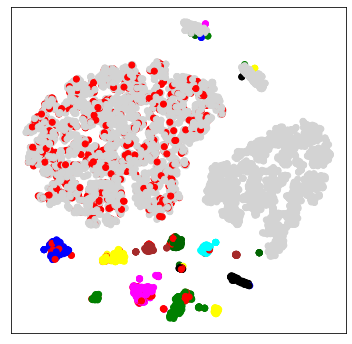

In [88]:
#x_min, x_max = np.min(X, 0), np.max(X, 0)
#X = (X - x_min) / (x_max - x_min)

fig, ax = plt.subplots(figsize=(6,6), nrows=1, ncols=1)

# Set color
#c = df['core'].map({True: 'red', False: 'blue'})
def modcolor(r):
    if r['core'] == True:
        return 'red'
    if r['module-1'] == True:
        return 'magenta'
    if r['module-2'] == True:
        return 'blue'
    if r['module-3'] == True:
        return 'green'
    if r['module-4'] == True:
        return 'cyan'
    if r['module-5'] == True:
        return 'brown'
    if r['module-6'] == True:
        return 'yellow'
    if r['module-11'] == True:
        return 'darkgreen'
    if r['module-12'] == True:
        return 'black'
    return 'lightgray'

c = df.apply(modcolor, axis=1)
#
ax.scatter(X_manifold[:,0], X_manifold[:,1], c=c)

ax.set_xticks([])
ax.set_yticks([])

In [50]:
dftc = df.loc[df['core']==True, :]
dftn = df.loc[df['core']!=True, :]

<AxesSubplot:ylabel='Frequency'>

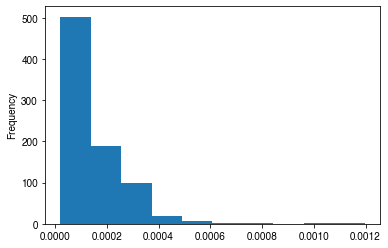

In [42]:
dftc['pagerank'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

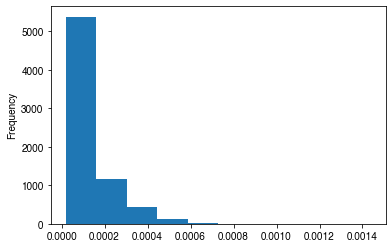

In [43]:
dftn['pagerank'].plot.hist()